In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

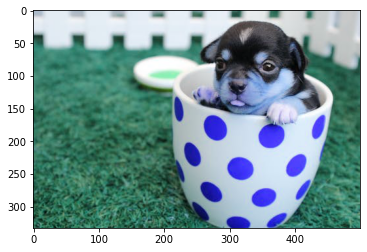

In [5]:
image = cv2.imread('chihuahua-dog-puppy-cute-39317_small.jpeg') 
cv2.imshow('Original Image', image)
plt.imshow(image)
plt.show()
cv2.waitKey(0)
cv2.destroyAllWindows()

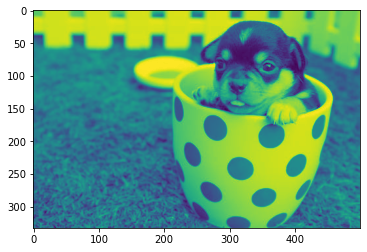

In [6]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #2D
cv2.imshow('GrayScale Image', gray)
plt.imshow(gray)
plt.show()
cv2.waitKey(0)
cv2.destroyAllWindows()

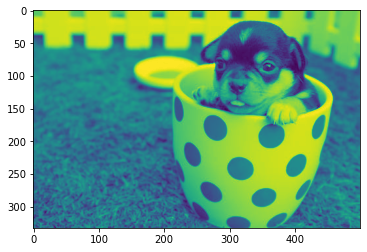

In [7]:
blurred_image = cv2.GaussianBlur(gray, (1,1),0)
cv2.imshow('Blurred Image', blurred_image)
plt.imshow(blurred_image)
plt.show()
cv2.waitKey(0)
cv2.destroyAllWindows()

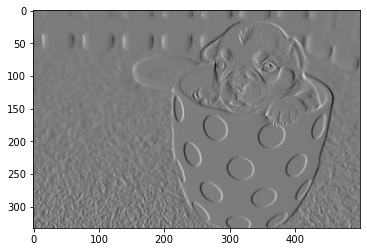

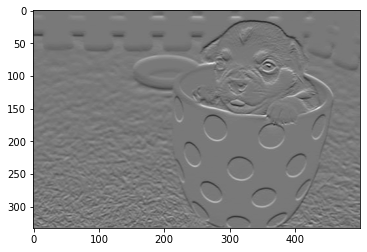

In [8]:
"""
SobelX = np.array([[-3,0,+3], [-10,0,+10],  [-3,0,+3]])
gx1 = ndimage.filters.convolve(blurred_image, SobelX)
#gx1 = GradientX/np.max(GradientX)
plt.imshow(gx1)
plt.show()

SobelY = np.array([[-3,-10,-3], [0,0,0], [+3,+10,+3]])
gy1 = ndimage.filters.convolve(blurred_image, SobelY)
#gy1 = GradientY/np.max(GradientY)
plt.imshow(gy1)
plt.show()
When I used this part result is not as good as opencv's canny detector.
"""

gx1=cv2.Sobel(np.float32(blurred_image),cv2.CV_64F,1,0,ksize=3)
gy1=cv2.Sobel(np.float32(blurred_image),cv2.CV_64F,0,1,ksize=3)
plt.imshow(gx1,cmap='gray')
plt.show()
plt.imshow(gy1,cmap='gray')
plt.show()



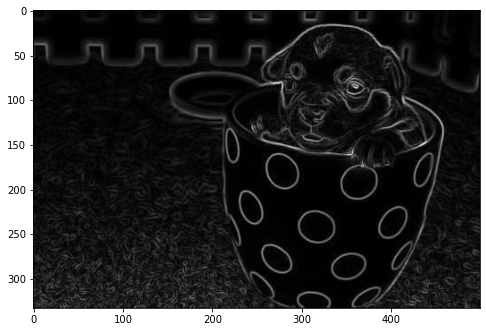

In [9]:

square_sum_gradient=gx1**2 + gy1**2
magnitude_grad= np.sqrt(square_sum_gradient)
Mag1= magnitude_grad*255.0/np.max(magnitude_grad)
plt.figure(figsize = (8,8))
plt.imshow(Mag1,cmap='gray')
plt.show()




In [10]:
calculate_radian=np.arctan2(gy1,gx1)
gradient_angles = np.degrees(calculate_radian)
gradient_angles

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 90.        ,  90.        ,  90.        , ...,   3.0127875 ,
          5.71059314,  90.        ],
       [ 90.        ,  90.        ,  90.        , ...,   3.0127875 ,
          2.72631099,  90.        ],
       ...,
       [ 90.        ,  44.35625429, 109.65382406, ..., -80.53767779,
        -47.86240523, -90.        ],
       [ 90.        ,  17.19854122, 153.43494882, ..., -77.27564431,
        -48.43363036, -90.        ],
       [  0.        ,   0.        , 180.        , ...,   0.        ,
          0.        ,   0.        ]])

In [11]:
gradient_angles[gradient_angles<0]+=180
gradient_angles


array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 90.        ,  90.        ,  90.        , ...,   3.0127875 ,
          5.71059314,  90.        ],
       [ 90.        ,  90.        ,  90.        , ...,   3.0127875 ,
          2.72631099,  90.        ],
       ...,
       [ 90.        ,  44.35625429, 109.65382406, ...,  99.46232221,
        132.13759477,  90.        ],
       [ 90.        ,  17.19854122, 153.43494882, ..., 102.72435569,
        131.56636964,  90.        ],
       [  0.        ,   0.        , 180.        , ...,   0.        ,
          0.        ,   0.        ]])

In [12]:
def NonMaxSup1(gradient_magnitude, gradient_degree):
    non_max = np.zeros(gradient_magnitude.shape)
    width=int(gradient_magnitude.shape[0]) - 1
    height=int(gradient_magnitude.shape[1])-1
    
    for i in range(1,width ):
        for j in range(1, height):
            #angle 0 
            if((0 <= gradient_degree[i,j] < 22.5 or 157.5 <= gradient_degree[i,j] <=180) ):
                x=gradient_magnitude[i, j - 1]
                y=gradient_magnitude[i, j + 1]
                compared_value = max(x,y)
            
            elif((22.5 <= gradient_degree[i,j] < 67.5 )):
                x=gradient_magnitude[i + 1, j - 1]
                y=gradient_magnitude[i - 1, j + 1]
                compared_value = max(x,y)
            
            elif((67.5 <= gradient_degree[i,j] < 122.5 )):
                x=gradient_magnitude[i - 1, j]
                y=gradient_magnitude[i+ 1, j]
                compared_value = max(x,y)
              
            elif((112.5 <= gradient_degree[i,j] < 157.5)):
                x=gradient_magnitude[i + 1, j + 1]
                y=gradient_magnitude[i - 1, j - 1]
                compared_value = max(x,y)
            else:
                non_max[i,j] = 0
                
            if((gradient_magnitude[i, j] >= compared_value)):
                 non_max[i, j] = gradient_magnitude[i, j]
    return non_max

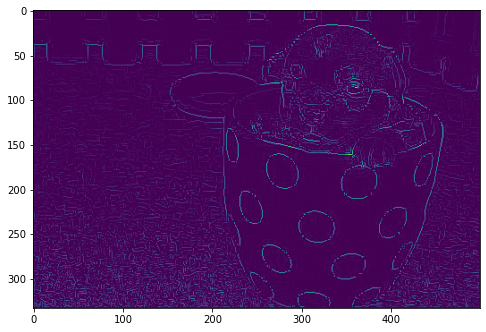

In [14]:
non_max_apply2= NonMaxSup1(Mag1,gradient_angles)
non_max_apply3 = non_max_apply2*255.0/np.max(Mag1)
plt.figure(figsize = (8,8))
plt.imshow(non_max_apply3)
plt.show()
cv2.imshow('The Suppressed Image', non_max_apply3)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [15]:
def doubleThreshold(suppressed_img):
    
   
    
    
    threshold_img = np.zeros((suppressed_img.shape), dtype=np.int32)
    
    #Min pixel
    lThreshold = np.int32(25) 
    
    #Max pixel
    hThreshold = np.int32(50)
    
    #intensity higher than high threshold
    highx, highy = np.where(suppressed_img >= hThreshold)
    
    #intensity lower than low threshold
    irrelevant_pixelx, irrelevant_pixely = np.where(suppressed_img < lThreshold)
    
    #intensity between high and low threshold
    lowx, lowy = np.where((suppressed_img <= hThreshold) & (suppressed_img >= lThreshold))
    
    threshold_img[highx, highy] = 250
    threshold_img[lowx, lowy] = 50
    
    return (threshold_img)


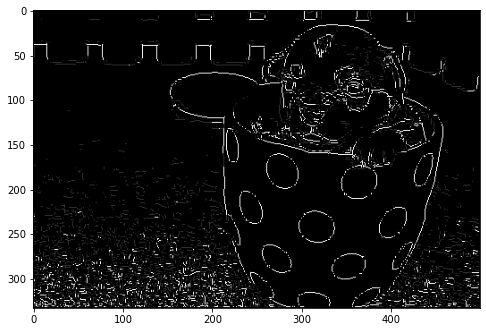

In [16]:
t_img=doubleThreshold(non_max_apply3)
plt.figure(figsize = (8,8))
plt.imshow(t_img, cmap='gray')


In [17]:
def edgeHysteresis(thresholded_img, low, high):
    
     
    
    for i in range(1, int(thresholded_img.shape[0]) - 1):
        for j in range(1,int(thresholded_img.shape[1]) - 1):
            if (thresholded_img[i,j] == low):
                
                    if ((thresholded_img[i+1, j-1] == high) 
                        or (thresholded_img[i+1, j] == high)
                        or (thresholded_img[i+1, j+1] == high)
                        or (thresholded_img[i, j-1] == high) 
                        or (thresholded_img[i, j+1] == high)
                        or (thresholded_img[i-1, j-1] == high) 
                        or (thresholded_img[i-1, j] == high) 
                        or (thresholded_img[i-1, j+1] == high)):
                        thresholded_img[i, j] = high
                    else:
                        thresholded_img[i, j] = 0
               
    
    return thresholded_img

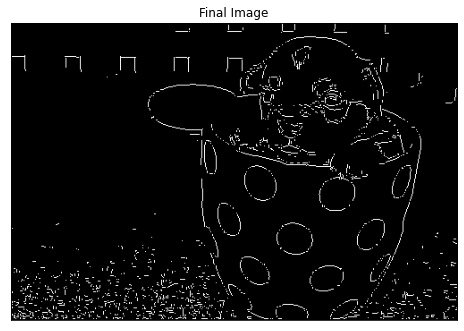

In [18]:

final_stage = edgeHysteresis(t_img, 50, 255)

plt.figure(figsize = (8,8))
plt.imshow(final_stage,cmap = 'gray')
plt.title('Final Image'), plt.xticks([]), plt.yticks([])
plt.show()
